In [ ]:
import acgan
import twodlearn as tdl
import twodlearn.debug
import tensorflow as tf
from types import SimpleNamespace
import acgan.model.encoder
from acgan.model.encoder import LinearEstimator
sess = tf.InteractiveSession()

#dataset_valid = acgan.data.load_fashion_mnist_3c(
dataset_valid = acgan.data.load_cifar10(
    32, split=tfds.Split.TEST, with_label=True)
dataset_valid = acgan.data.to_one_hot(dataset_valid, 10)
valid_data = tf.compat.v1.data.make_one_shot_iterator(
    dataset_valid).get_next()

#dataset = acgan.data.load_mnist32_3c(32)
#dataset = acgan.data.load_fashion_mnist_3c(32, with_label=True)
dataset = acgan.data.load_cifar10(32, with_label=True)
#dataset = acgan.data.load_stl10(32, with_label=True)
#dataset = acgan.data.load_celeb_a(32, with_label=True)
dataset = acgan.data.to_one_hot(dataset, 10)

In [ ]:
import tensorflow_datasets as tfds
def load_splits(name, batch_size=64):
    def load_split(split):
        dataset = acgan.data.load(
            name, batch_size, split=split, 
            with_label=True)
        dataset = acgan.data.to_one_hot(dataset, 10)
        return tf.compat.v1.data.make_one_shot_iterator(
            dataset).get_next()
    return SimpleNamespace(
        train=load_split(tfds.Split.TRAIN),
        valid=load_split(tfds.Split.TEST))
    
data = load_splits('cifar10')
train_data = data.train
valid_data = data.valid

In [ ]:
estimator = LinearEstimator(
    model={'n_classes': 10, 
           'encoder': {
               'embedding_size': 512,
               'layers': {
                   'units': [64, 128, 256, 512],
                   'kernels': 3,
                   'strides': 1,
                   'pooling': 2,
                   'flatten': 'global_maxpool'}}},
    loss={'value':'crossentropy', 'from_logits': True},
    metrics={'metrics': ['accuracy'], 'from_logits': True},
    optimizer={'learning_rate': 0.02}
)
estimator.compile(train_data['image'], train_data['label'])
estimator.trainable_variables = tdl.core.get_trainable(estimator.model)
optim = estimator.get_optimizer(
    train_data['image'], train_data['label'],
    progress={'reset_multiplier': 3.0},
    learning_rate=0.002)

In [25]:
optim.run(n_steps=10000)

step 70000 | acc 0.9916| loss 0.0324: 100%|█████████▉| 9980/9999 [08:24<00:00, 19.78it/s]         


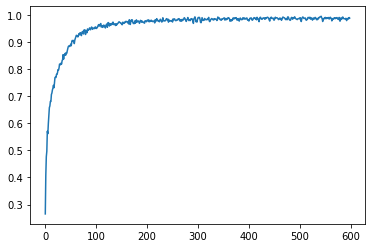

In [24]:
import matplotlib.pyplot as plt
# plt.plot(optim.metrics['loss'].as_numpy())
plt.plot(optim.metrics['acc'].as_numpy())

In [23]:
acc = list()
for i in range(500):
    valid = sess.run(valid_data)
    results = estimator.evaluate(inputs=valid['image'], labels=valid['label'])
    acc.append(results['metrics']['acc'])
sum(acc)/len(acc)

0.818625

In [13]:
import numpy as np 
np.argmax(results['pred'], -1)

array([0, 5, 6, 1, 3, 7, 2, 6, 5, 0, 5, 0, 3, 2, 1, 2, 6, 7, 4, 8, 6, 2,
       9, 1, 1, 3, 5, 7, 0, 7, 8, 0, 3, 4, 1, 5, 3, 9, 2, 7, 2, 5, 7, 9,
       0, 7, 7, 1, 3, 1, 6, 8, 4, 7, 5, 5, 3, 7, 5, 9, 3, 8, 4, 3, 3, 2,
       2, 3, 0, 5, 3, 7, 4, 8, 0, 9, 8, 5, 0, 5, 2, 3, 0, 2, 6, 1, 5, 0,
       6, 3, 0, 7, 5, 3, 9, 9, 0, 9, 1, 8, 1, 0, 3, 5, 0, 5, 9, 9, 9, 9,
       2, 6, 1, 9, 9, 1, 0, 3, 9, 0, 8, 9, 5, 0, 9, 9, 4, 3])

In [14]:
np.argmax(valid['label'], -1)

array([0, 5, 6, 1, 5, 7, 2, 6, 5, 0, 5, 0, 5, 2, 9, 2, 4, 7, 4, 8, 6, 2,
       0, 9, 1, 4, 3, 5, 0, 7, 8, 0, 3, 0, 1, 5, 9, 9, 2, 5, 6, 5, 2, 9,
       4, 7, 7, 1, 3, 1, 6, 0, 0, 5, 5, 5, 3, 7, 5, 9, 3, 8, 5, 5, 4, 3,
       2, 5, 0, 5, 3, 7, 4, 6, 0, 9, 6, 2, 0, 5, 2, 3, 1, 2, 6, 1, 5, 0,
       6, 3, 8, 7, 5, 3, 9, 9, 0, 9, 1, 8, 1, 0, 3, 4, 0, 5, 9, 9, 9, 9,
       2, 6, 1, 9, 9, 9, 0, 5, 9, 0, 8, 9, 5, 0, 9, 9, 4, 3])

# check output dimensions

In [22]:
resnet = estimator.model.encoder.model.layers.layers
outputs = [train_data['image']]
for layer in resnet:
    outputs.append(layer(outputs[-1])) 

In [23]:
outputs

[<tf.Tensor 'IteratorGetNext:0' shape=(?, 32, 32, 3) dtype=float32>,
 <tf.Tensor 'LinearEstimator/model/LinearClassifier/encoder/ResConv/layers/ResConv2D_4/add:0' shape=(?, 32, 32, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 16, 16, 32) dtype=float32>,
 <tf.Tensor 'LinearEstimator/model/LinearClassifier/encoder/ResConv/layers/ResConv2D_1_1/add:0' shape=(?, 16, 16, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_1/MaxPool:0' shape=(?, 8, 8, 64) dtype=float32>,
 <tf.Tensor 'LinearEstimator/model/LinearClassifier/encoder/ResConv/layers/ResConv2D_2_1/add:0' shape=(?, 8, 8, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_2/MaxPool:0' shape=(?, 4, 4, 64) dtype=float32>,
 <tf.Tensor 'LinearEstimator/model/LinearClassifier/encoder/ResConv/layers/ResConv2D_3_1/add:0' shape=(?, 4, 4, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_3/MaxPool:0' shape=(?, 2, 2, 64) dtype=float32>,
 <tf.Tensor 'flatten/Reshape:0' shape=(?, 256) dtype=float32>,

# From GAN

In [1]:
import acgan
from acgan.data.remote import RemoteShare
from acgan.main import ExperimentGMM, ExperimentWACGAN

import twodlearn as tdl
import twodlearn.debug
import tensorflow as tf
from types import SimpleNamespace
import acgan.model.encoder
from acgan.model.encoder import LinearEstimator
sess = tf.InteractiveSession()

In [2]:
remote = RemoteShare(model='wacgan')
session_path = remote.download('session_20200604_0816_cifar10')

In [ ]:
experiment = ExperimentWACGAN.restore_session(
    session_path=session_path,
    dataset_name='cifar10',
    indicator='cifar10_test')

In [4]:
import tensorflow_datasets as tfds
def load_splits(name, batch_size=128):
    def load_split(split):
        dataset = acgan.data.load(
            name, batch_size, split=split, 
            with_label=True)
        dataset = acgan.data.to_one_hot(dataset, 10)
        return tf.compat.v1.data.make_one_shot_iterator(
            dataset).get_next()
    return SimpleNamespace(
        train=load_split(tfds.Split.TRAIN),
        valid=load_split(tfds.Split.TEST))
    
data = load_splits('cifar10')
train_data = data.train
valid_data = data.valid

In [21]:
from acgan.model.encoder import CallWrapper, MlpEstimator

encoder = CallWrapper(
    model=experiment.model.encoder,
    call_fn=lambda model, x: model(x).mean())
#encoder = tdl.stacked.StackedLayers(
#    layers=experiment.model.encoder.layers[:-2])

estimator = MlpEstimator(
    model={'n_classes': 10, 
           'units': [128],
           'encoder': encoder},
    loss={'value':'crossentropy', 'from_logits': True},
    metrics={'metrics': ['accuracy'], 'from_logits': True},
    optimizer={'learning_rate': 0.02}
)
estimator.compile(train_data['image'], train_data['label'])
estimator.trainable_variables = tdl.core.get_trainable(
    estimator.model.classifier)
optim = estimator.get_optimizer(
    train_data['image'], train_data['label'],
    progress={'reset_multiplier': 3.0})

In [24]:
optim.run(n_steps=10000)

step 19990 | acc 0.6495| loss 1.0088: : 10000it [03:31, 47.33it/s]                       


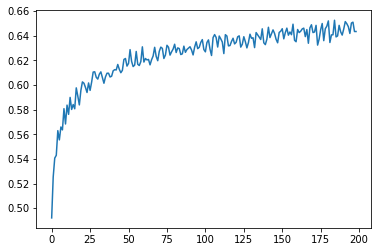

In [25]:
import matplotlib.pyplot as plt
# plt.plot(optim.metrics['loss'].as_numpy())
plt.plot(optim.metrics['acc'].as_numpy())

In [26]:
acc = list()
for i in range(500):
    valid = sess.run(valid_data)
    results = estimator.evaluate(inputs=valid['image'], labels=valid['label'])
    acc.append(results['metrics']['acc'])
sum(acc)/len(acc)

0.64709375

In [28]:
estimator.model.encoder.model.layers

In [29]:
resnet = estimator.model.encoder.model.layers
outputs = [train_data['image']]
for layer in resnet:
    outputs.append(layer(outputs[-1])) 
outputs

[<tf.Tensor 'IteratorGetNext_1:0' shape=(?, 32, 32, 3) dtype=float32>,
 <tf.Tensor 'WacGan/encoder/ResConv2D_3/add:0' shape=(?, 32, 32, 32) dtype=float32>,
 <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 16, 16, 32) dtype=float32>,
 <tf.Tensor 'WacGan/encoder/ResConv2D_1_1/add:0' shape=(?, 16, 16, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_1/MaxPool:0' shape=(?, 8, 8, 64) dtype=float32>,
 <tf.Tensor 'WacGan/encoder/ResConv2D_2_1/add:0' shape=(?, 8, 8, 64) dtype=float32>,
 <tf.Tensor 'max_pooling2d_2/MaxPool:0' shape=(?, 4, 4, 64) dtype=float32>,
 <tf.Tensor 'flatten/Reshape:0' shape=(?, 1024) dtype=float32>,
 <tfp.distributions.Normal 'WacGan_encoder_NormalModel_1_Normal' batch_shape=[?, 128] event_shape=[] dtype=float32>]

# Linear Baseline

In [1]:
import acgan
import twodlearn as tdl
import twodlearn.debug
import tensorflow as tf
from types import SimpleNamespace
import acgan.model.encoder
from acgan.model.encoder import LinearEstimator
sess = tf.InteractiveSession()
SPARSE = False

In [ ]:
import tensorflow_datasets as tfds
def load_splits(name, batch_size=128, sparse=False):
    def load_split(split):
        dataset = acgan.data.load(
            name, batch_size, split=split, 
            with_label=True)
        if not sparse:
            dataset = acgan.data.to_one_hot(dataset, 10)
        return tf.compat.v1.data.make_one_shot_iterator(
            dataset).get_next()
    return SimpleNamespace(
        train=load_split(tfds.Split.TRAIN),
        valid=load_split(tfds.Split.TEST))
    
data = load_splits('cifar10', sparse=SPARSE)
train_data = data.train
valid_data = data.valid

In [165]:
estimator = LinearEstimator(
    model={'n_classes': 10, 
           'encoder': tdl.stacked.StackedLayers(
               layers=[tf.keras.layers.Flatten(),
                       tf.keras.layers.Dense(units=512),
                       tf.keras.layers.LeakyReLU(0.2)])},
    loss={'value':('sparse_crossentropy' if SPARSE
                   else 'crossentropy'), 
          'from_logits': True},
    metrics={'metrics': ['accuracy'], 
             'from_logits': True, 'sparse': SPARSE},
    optimizer={'learning_rate': 0.002}
)
estimator.compile(train_data['image'], train_data['label'])
estimator.trainable_variables = tdl.core.get_trainable(estimator.model)
optim = estimator.get_optimizer(
    train_data['image'], train_data['label'])

In [211]:
optim.run(n_steps=10000)

step 149980 | acc 0.8514| loss 18.7027: : 10000it [00:42, 237.34it/s]                       


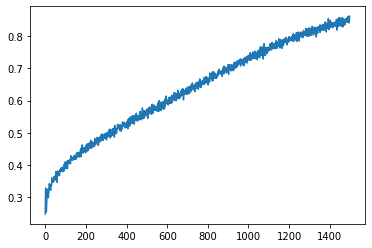

In [212]:
import matplotlib.pyplot as plt
#plt.plot(optim.metrics['loss'].as_numpy())
plt.plot(optim.metrics['acc'].as_numpy())

In [213]:
acc = list()
for i in range(500):
    valid = sess.run(valid_data)
    results = estimator.evaluate(inputs=valid['image'], labels=valid['label'])
    acc.append(results['metrics']['acc'])
sum(acc)/len(acc)

0.44428125

## Using keras

In [ ]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(32,32,3), name="image"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dense(units=10),])
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(
        from_logits=True),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model.fit(train_data['image'], train_data['label'],
          steps_per_epoch=10000)

In [ ]:
model.evaluate(valid_data['image'], valid_data['label'],
               steps=1000)

In [ ]:
import numpy as np
valid = sess.run(valid_data)
logits = model.predict(valid['image'], batch_size=128)
pred = np.exp(logits)/np.sum(np.exp(logits), -1)[..., np.newaxis]

In [ ]:
np.mean(np.argmax(logits, -1) == np.argmax(valid['label'], -1))

In [22]:
import numpy as np
np.exp(results['pred'])/np.sum(np.exp(results['pred']), -1)[..., np.newaxis]

/data/marinodl/research/2019/AssociativeGAN/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/data/marinodl/research/2019/AssociativeGAN/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([[0.00000000e+00,            nan, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.18361240e-28, 9.91849244e-01, 1.19110369e-43, ...,
        1.45975090e-08, 0.00000000e+00, 8.15080758e-03],
       [3.61498314e-14, 1.06597043e-04, 4.74601795e-25, ...,
        5.41808352e-15, 0.00000000e+00, 4.73316669e-01],
       ...,
       [3.57881728e-20, 1.39531163e-24, 9.30961207e-15, ...,
        1.43019441e-23, 0.00000000e+00, 0.00000000e+00],
       [1.79401962e-35, 0.00000000e+00, 1.60247612e-15, ...,
        5.37535980e-19, 0.00000000e+00, 0.00000000e+00],
       [9.99987483e-01, 7.13749781e-36, 2.62295899e-37, ...,
        5.39152790e-37, 0.00000000e+00, 1.24738635e-05]], dtype=float32)

In [19]:
np.argmax(valid['label'], -1)

array([9, 5, 2, 8, 1, 0, 3, 3, 1, 8, 6, 3, 5, 4, 9, 4, 1, 3, 0, 7, 0, 1,
       4, 1, 0, 1, 5, 2, 2, 4, 2, 2, 1, 0, 4, 9, 8, 9, 6, 1, 1, 4, 0, 8,
       2, 2, 1, 7, 6, 2, 1, 5, 6, 2, 8, 5, 9, 4, 5, 4, 4, 0, 7, 5, 1, 9,
       5, 5, 1, 2, 3, 9, 5, 1, 5, 9, 5, 2, 0, 9, 6, 4, 2, 8, 5, 7, 7, 6,
       7, 4, 2, 5, 5, 7, 1, 0, 6, 1, 6, 1, 2, 0, 1, 7, 9, 5, 5, 2, 1, 8,
       8, 1, 5, 5, 7, 8, 5, 4, 7, 0, 7, 2, 9, 7, 0, 8, 9, 4])

In [18]:
np.argmax(results['pred'], -1)

array([9, 4, 2, 1, 0, 0, 3, 5, 1, 0, 4, 2, 7, 4, 9, 3, 1, 0, 0, 3, 7, 1,
       2, 1, 0, 7, 1, 7, 4, 4, 0, 4, 1, 0, 4, 9, 8, 1, 4, 1, 1, 8, 0, 8,
       2, 0, 1, 7, 9, 3, 1, 5, 3, 7, 0, 5, 0, 4, 5, 0, 6, 0, 7, 4, 8, 9,
       7, 5, 1, 9, 5, 9, 3, 1, 5, 9, 3, 4, 0, 9, 6, 4, 4, 8, 5, 3, 4, 3,
       7, 3, 2, 5, 3, 7, 1, 2, 0, 7, 4, 0, 2, 0, 2, 9, 9, 7, 4, 0, 1, 0,
       6, 9, 0, 7, 9, 4, 5, 4, 7, 0, 4, 4, 8, 4, 0, 8, 2, 0])

In [30]:
estimator.model.encoder.layers

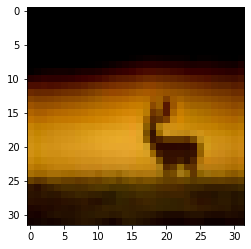

In [26]:

plt.imshow(valid_data['image'].eval()[0, ...])